In [1]:
# Just the normal prequisites for using matplotlib and numpy in a Jupyter notebook
%matplotlib inline
# Use the svg backend, in my opinion it just makes better looking plots
%config InlineBackend.figure_format = 'svg'

import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging( logging_level='INFO')

import os
import sys
from pathlib import Path
import IPython
from scipy import signal
import scipy.fftpack
from PySpice.Unit import *
from PySpice.Spice.Parser import SpiceParser
from PySpice.Spice.Netlist import Circuit, SubCircuit, SubCircuitFactory
from PySpice.Spice.Library import SpiceLibrary
from PySpice.Probe.Plot import plot
from PySpice.Doc.ExampleTools import find_libraries
from PySpice.Math import *
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import unittest

import schemdraw
import schemdraw.elements as elm
from schemdraw import logic
from schemdraw import dsp

directory_path = Path(os.path.abspath('')).resolve().parent.parent
spice_libraries_path = directory_path.joinpath("lib", "spice")
spice_library = SpiceLibrary(spice_libraries_path)

directory_path = Path(os.path.abspath('')).resolve()

2021-12-20 14:02:28,431 - PySpice.Spice.Parser.Element.read_words - WARNING - Bad element line, looking for word 1/2:
SICC VCC GND VCC GND SW1 
                         ^
2021-12-20 14:02:28,432 - PySpice.Spice.Parser.SpiceParser._parse - WARNING - Parse error on:
SICC VCC GND VCC GND SW1 
2021-12-20 14:02:28,432 - PySpice.Spice.Parser.Element.read_words - WARNING - Bad element line, looking for word 1/2:
SIOFF OUTsw OUT VCC GND SW2 
                            ^
2021-12-20 14:02:28,433 - PySpice.Spice.Parser.SpiceParser._parse - WARNING - Parse error on:
SIOFF OUTsw OUT VCC GND SW2 
2021-12-20 14:02:28,436 - PySpice.Spice.Parser.Element.read_words - WARNING - Bad element line, looking for word 1/2:
ST2 vdd phcmpii s1 0 swt
                     ^
2021-12-20 14:02:28,436 - PySpice.Spice.Parser.SpiceParser._parse - WARNING - Parse error on:
ST2 vdd phcmpii s1 0 swt
2021-12-20 14:02:28,437 - PySpice.Spice.Parser.Element.read_words - WARNING - Bad element line, looking for word 1/2:
SB2 ph

In [2]:
class VoltageDivider(SubCircuitFactory):
    __name__ = 'voltage_divider'
    __nodes__ = ('n1', 'n2', 'n3' )
    __R = 100@u_kΩ

    def __init__(self, R=100@u_kΩ, w=0.4, name='voltage_divider'):
        self.__R__ = R
        SubCircuit.__init__(self, name, *self.__nodes__)
        self.R(1, 'n1', 'n2', R * w)
        self.R(2, 'n2', 'n3', R * (1.0-w) )
        
    def wiper(self, w) :
        if w == 0 :
            self.R1.resistance = self.__R * 0.0000001
            self.R2.resistance = self.__R * 0.9999999
        elif w == 1 :
            self.R1.resistance = self.__R * 0.9999999
            self.R2.resistance = self.__R * 0.0000001
        else :
            self.R1.resistance = self.__R * w
            self.R2.resistance = self.__R * (1.0-w)
        

# about

In the ringmodulator article various discrete differential amplifiers were analysed. We will now an OTA can be replaced with a discrete circuit.


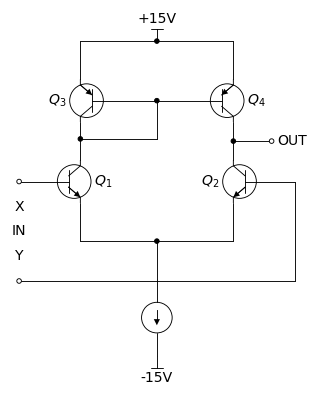

In [3]:
d = schemdraw.Drawing(unit=2.5, inches_per_unit=0.5, lw=0.9)


d += ( Q1 := elm.BjtNpn( label='$Q_1$', circle=True))
d += elm.Line("up").length(d.unit/2)
d += ( Q3 := elm.BjtPnp(circle=True).anchor("collector").right().reverse().label('$Q_3$', 'left') )
d += elm.Line().up().at(Q3.emitter).length(d.unit/2)
d += elm.Line().right().length(d.unit)
d += ( vdd := elm.Vdd(label="+15V") )

d += elm.Line().at(Q3.base).right().tox(vdd.end)
d += elm.Line().down().length(d.unit/2)
d += elm.Line().left().tox(Q3.collector)
d += elm.Dot()

d += ( IN_X := elm.Line("left", l=d.unit/2, xy=Q1.base))
d += elm.Dot('left', open=True)

d += ( L_Q1_emmitter := elm.Line("down",  xy=Q1.emitter, l=d.unit/2))
d += elm.Line("right", l=d.unit)
d += elm.Dot()
d.push()
d += elm.Line("right", l=d.unit)
d += elm.Line("up", l=d.unit/2)
d += ( Q2 := elm.BjtNpn("right", lftlabel='$Q_2$', anchor="emitter", circle=True, reverse=True))
d += elm.Line().up().at(Q2.collector).length(d.unit/4)
d.push()
d += elm.Line().up().length(d.unit/4)
d += ( Q4 := elm.BjtPnp(circle=True).anchor("collector").right().label('$Q_4$', loc='right') )
d += elm.Line().up().at(Q4.emitter).length(d.unit/2)
d += elm.Line().left()
d += elm.Dot()

d.pop()
d += elm.Dot()
d += elm.Line().right().length(d.unit/2)
d += elm.Dot('left', open=True).label('OUT', loc='right')

d.pop()
d += elm.Line().length(d.unit/2).down()
d += elm.SourceI().down()
d += elm.Vss().label('-15V', loc='bottom')

d += elm.Line().at(Q4.base).left().tox(vdd.end)
d += elm.Dot()

d += (elm.Line("right", xy=Q2.base, l=d.unit/2))
d += (elm.Line("down", l=d.unit*1.3))
d += ( IN_Y := elm.Line().left().tox(IN_X.end))
d += elm.Dot('left', open=True)

d += (elm.Gap('down', xy=IN_X.end, toy=IN_Y.end, label=['X', 'IN', 'Y']))
d.draw()

In [4]:
kicad_netlist_path = directory_path.joinpath('main', 'Voltage_Reference.cir')
parser = SpiceParser(path=str(kicad_netlist_path))

circuit = parser.build_circuit(ground=5)
circuit.include(spice_library['TL072c'])
circuit.include(spice_library['TL431'])


circuit.V('1', '+15V', circuit.gnd, 'DC 15')
circuit.V('2', '-15V', circuit.gnd, 'DC -15')

simulator = circuit.simulator(temperature=25, nominal_temperature=25)
simulator.options('INTERP')
analysis_dc = simulator.operating_point()

print(f"Positive 5V: {float(analysis_dc['+5V'])}, Negative 5V: {float(analysis_dc['-5V'])}")

Positive 5V: 4.990626381526843, Negative 5V: -4.990556300045098


2021-12-20 14:02:29,203 - PySpice.Spice.Netlist.Circuit.include - WARNING - Duplicated include


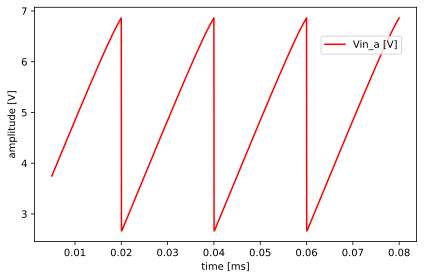

CV: 2.222224252975122


In [5]:
kicad_netlist_path = directory_path.joinpath('main', 'input.cir')
parser = SpiceParser(path=str(kicad_netlist_path))

circuit = parser.build_circuit(ground=5)
circuit.include(spice_library['BC846B']) #NPN
circuit.include(spice_library['BC556B']) #PNP
circuit.include(spice_library['TL072c'])
circuit.include(spice_library['LM13700d'])
circuit.include(spice_library['D1N4148'])
circuit.include(spice_library['TL431'])

circuit.V('1', '+15V', circuit.gnd, 'DC 15')
circuit.V('2', '-15V', circuit.gnd, 'DC -15')
circuit.V('3', '+5V', circuit.gnd, 'DC 5')

class JackIn(SubCircuitFactory):
    __name__ = 'IN'
    __nodes__ = ('n1', 'n2', 'n3' )
    def __init__(self, R=1@u_kΩ, name='IN', value='DC 5 Pulse(-5 5 0 0 20m 0.1m 20m)'):
        self.__name__ = name
        SubCircuit.__init__(self, name, *self.__nodes__)
        self.V(1, 'n2', self.gnd, value)

class JackCV(SubCircuitFactory):
    __name__ = 'CV'
    __nodes__ = ('n1', 'n2', 'n3' )
    def __init__(self, R=1@u_kΩ, name='CV', value='DC 0'):
        self.__name__ = name
        SubCircuit.__init__(self, name, *self.__nodes__)
        self.V(1, 'n2', self.gnd, value)

class JackLevel(SubCircuitFactory):
    __name__ = 'CV'
    __nodes__ = ('n1', 'n2', 'n3' )
    def __init__(self, R=1@u_kΩ, name='LEVEL', value='DC 0'):
        self.__name__ = name
        SubCircuit.__init__(self, name, *self.__nodes__)
        self.V(1, 'n2', self.gnd, value)

class JackOut(SubCircuitFactory):
    __name__ = 'OUT'
    __nodes__ = ('n1', 'n2', 'n3' )
    def __init__(self, R=100@u_kΩ, name='OUT'):
        self.__name__ = name
        SubCircuit.__init__(self, name, *self.__nodes__)
        self.R(1, 'n2', 'n3', R)

for c in ( VoltageDivider(R=50@u_kΩ, w=0.5, name='POT'),\
           VoltageDivider(R=50@u_kΩ, w=0.9, name='TRIM'),\
           VoltageDivider(R=50@u_kΩ, w=0.5, name='POT_CV'),\
           VoltageDivider(R=50@u_kΩ, w=0.5, name='POT_LEVEL'),\
           JackIn(), JackOut(), JackCV(), JackLevel() ) :
        circuit.subcircuit(c)

simulator = circuit.simulator(temperature=25, nominal_temperature=25)
simulator.options('INTERP')
analysis = simulator.transient(step_time=1@u_us, start_time=5@u_ms, end_time=80@u_ms)
analysis_dc = simulator.operating_point()
    

fig_buffer, ax1_buffer = plt.subplots()

ax1_buffer.set_xlabel('time [ms]')
ax1_buffer.set_ylabel('amplitude [V]')
ax1_buffer.plot(analysis['/IN'].abscissa, analysis['/IN'], color='Red')
ax1_buffer.legend(('Vin_a [V]', 'Vin_b', 'Vout [V]'), loc=(0.75,0.8))

plt.tight_layout()
plt.show()


print(f"CV: {float(analysis_dc['Net-_R4-Pad2_'])}")

2021-12-20 14:03:21,255 - PySpice.Spice.Netlist.Circuit.include - WARNING - Duplicated include
.title KiCad schematic
.include /github/workspace/lib/spice/transistor/bc5x7.lib
.include /github/workspace/lib/spice/opamp/TL072-dual.lib
.include /github/workspace/lib/spice/opamp/LM13700d.MOD
.include /github/workspace/lib/spice/diode/1N4148.mod
.include /github/workspace/lib/spice/regulator/TL431mod.lib
Q12 /OUTa Net-_Q12-Pad2_ Net-_Q1-Pad3_ BC846B
R16 Net-_Q12-Pad2_ Net-_Q14-Pad2_ 750
Q13 Net-_Q12-Pad2_ Net-_Q13-Pad2_ Net-_Q13-Pad3_ BC556B
R15 Net-_Q13-Pad3_ +15V 51k
Q14 /OUTb Net-_Q14-Pad2_ Net-_Q1-Pad3_ BC846B
R18 Net-_Q14-Pad2_ Net-_Q16-Pad2_ 750
Q15 Net-_Q14-Pad2_ Net-_Q13-Pad2_ Net-_Q15-Pad3_ BC556B
R17 Net-_Q15-Pad3_ +15V 51k
Q16 /OUTa Net-_Q16-Pad2_ Net-_Q1-Pad3_ BC846B
R20 Net-_Q16-Pad2_ Net-_Q18-Pad2_ 750
Q17 Net-_Q16-Pad2_ Net-_Q13-Pad2_ Net-_Q17-Pad3_ BC556B
R19 Net-_Q17-Pad3_ +15V 51k
Q18 /OUTb Net-_Q18-Pad2_ Net-_Q1-Pad3_ BC846B
R22 Net-_Q18-Pad2_ Net-_Q20-Pad2_ 750
Q19 Net-

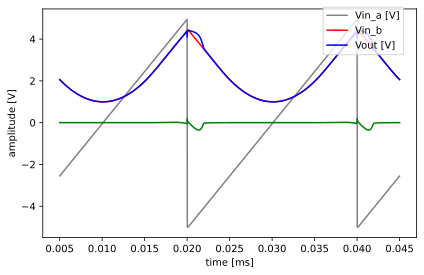

In [7]:
kicad_netlist_path = directory_path.joinpath('main', 'core.cir')
parser = SpiceParser(path=str(kicad_netlist_path))

circuit = parser.build_circuit(ground=5)
circuit.include(spice_library['BC846B']) #NPN
circuit.include(spice_library['BC556B']) #PNP
circuit.include(spice_library['TL072c'])
circuit.include(spice_library['LM13700d'])
circuit.include(spice_library['D1N4148'])
circuit.include(spice_library['TL431'])


circuit.V('1', '+15V', circuit.gnd, 'DC 15')
circuit.V('2', '-15V', circuit.gnd, 'DC -15')
circuit.V('3', '+5V', circuit.gnd, 'DC 5')
circuit.V('4', '-5V', circuit.gnd, 'DC -5')
circuit.V('5', '/IN', circuit.gnd, 'DC 5 Pulse(5 -5 0 0m 20m 0.1m 20m)')

print(circuit)

simulator = circuit.simulator(temperature=25, nominal_temperature=25)
simulator.options('INTERP')
analysis = simulator.transient(step_time=10@u_us, start_time=5@u_ms, end_time=45@u_ms)
analysis_dc = simulator.operating_point()
    
fig_buffer, ax1_buffer = plt.subplots()

ax1_buffer.set_xlabel('time [ms]')
ax1_buffer.set_ylabel('amplitude [V]')
ax1_buffer.plot(analysis['/IN'].abscissa, analysis['/IN'], color='Grey')
ax1_buffer.plot(analysis['/OUTa'].abscissa, analysis['/OUTa'], color='Red')
ax1_buffer.plot(analysis['/OUTb'].abscissa, analysis['/OUTb'], color='Blue')
ax1_buffer.plot(analysis['/OUTb'].abscissa, analysis['/OUTa'] - analysis['/OUTb'], color='Green')
ax1_buffer.legend(('Vin_a [V]', 'Vin_b', 'Vout [V]'), loc=(0.75,0.8))

plt.tight_layout()
plt.show()


#print(f"CV_Voltage: {float(analysis_dc['Net-_R4-Pad2_'])}")
#print(f"U2A input Voltage: {float(analysis_dc['Net-_R13-Pad2_'])}")
#print(f"U2A output Voltage: {float(analysis_dc['Net-_Q1-Pad2_'])}")


2021-12-20 14:11:05,369 - PySpice.Spice.Netlist.Circuit.include - WARNING - Duplicated include
.title KiCad schematic
.include /github/workspace/lib/spice/transistor/bc5x7.lib
.include /github/workspace/lib/spice/opamp/TL072-dual.lib
.include /github/workspace/lib/spice/opamp/LM13700d.MOD
.include /github/workspace/lib/spice/diode/1N4148.mod
.include /github/workspace/lib/spice/regulator/TL431mod.lib
.subckt POT n1 n2 n3
R1 n1 n2 25.0kOhm
R2 n2 n3 25.0kOhm
.ends POT

.subckt TRIM n1 n2 n3
R1 n1 n2 45.0kOhm
R2 n2 n3 4.999999999999999kOhm
.ends TRIM

.subckt POT_CV n1 n2 n3
R1 n1 n2 25.0kOhm
R2 n2 n3 25.0kOhm
.ends POT_CV

.subckt POT_LEVEL n1 n2 n3
R1 n1 n2 25.0kOhm
R2 n2 n3 25.0kOhm
.ends POT_LEVEL

.subckt IN n1 n2 n3
V1 n2 0 DC 5 Pulse(-5 5 0 0 20m 0.1m 20m)
.ends IN

.subckt OUT n1 n2 n3
R1 n2 n3 100kOhm
.ends OUT

.subckt CV n1 n2 n3
V1 n2 0 DC 0
.ends CV

.subckt LEVEL n1 n2 n3
V1 n2 0 DC 0
.ends LEVEL
XU3 Net-_Q1-Pad2_ Net-_R17-Pad1_ GND -15V GND Net-_C6-Pad2_ -5V +15V TL072c
XU2

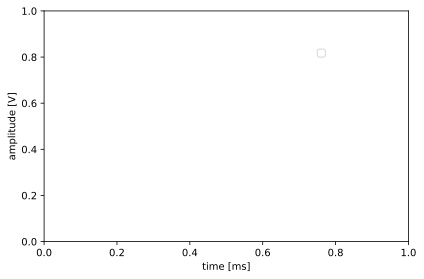

In [13]:
kicad_netlist_path = directory_path.joinpath('main', 'main.cir')
parser = SpiceParser(path=str(kicad_netlist_path))

circuit = parser.build_circuit(ground=5)
circuit.include(spice_library['BC846B']) #NPN
circuit.include(spice_library['BC556B']) #PNP
circuit.include(spice_library['TL072c'])
circuit.include(spice_library['LM13700d'])
circuit.include(spice_library['D1N4148'])
circuit.include(spice_library['TL431'])


circuit.V('1', '+15V', circuit.gnd, 'DC 15')
circuit.V('2', '-15V', circuit.gnd, 'DC -15')
circuit.V('3', '+5V', circuit.gnd, 'DC 5')
circuit.V('4', '-5V', circuit.gnd, 'DC -5')

class JackIn(SubCircuitFactory):
    __name__ = 'IN'
    __nodes__ = ('n1', 'n2', 'n3' )
    def __init__(self, R=1@u_kΩ, name='IN', value='DC 5 Pulse(-5 5 0 0 20m 0.1m 20m)'):
        self.__name__ = name
        SubCircuit.__init__(self, name, *self.__nodes__)
        self.V(1, 'n2', self.gnd, value)

class JackCV(SubCircuitFactory):
    __name__ = 'CV'
    __nodes__ = ('n1', 'n2', 'n3' )
    def __init__(self, R=1@u_kΩ, name='CV', value='DC 0'):
        self.__name__ = name
        SubCircuit.__init__(self, name, *self.__nodes__)
        self.V(1, 'n2', self.gnd, value)

class JackLevel(SubCircuitFactory):
    __name__ = 'CV'
    __nodes__ = ('n1', 'n2', 'n3' )
    def __init__(self, R=1@u_kΩ, name='LEVEL', value='DC 0'):
        self.__name__ = name
        SubCircuit.__init__(self, name, *self.__nodes__)
        self.V(1, 'n2', self.gnd, value)

class JackOut(SubCircuitFactory):
    __name__ = 'OUT'
    __nodes__ = ('n1', 'n2', 'n3' )
    def __init__(self, R=100@u_kΩ, name='OUT'):
        self.__name__ = name
        SubCircuit.__init__(self, name, *self.__nodes__)
        self.R(1, 'n2', 'n3', R)

for c in ( VoltageDivider(R=50@u_kΩ, w=0.5, name='POT'),\
           VoltageDivider(R=50@u_kΩ, w=0.9, name='TRIM'),\
           VoltageDivider(R=50@u_kΩ, w=0.5, name='POT_CV'),\
           VoltageDivider(R=50@u_kΩ, w=0.5, name='POT_LEVEL'),\
           JackIn(), JackOut(), JackCV(), JackLevel() ) :
        circuit.subcircuit(c)

print(circuit)

simulator = circuit.simulator(temperature=25, nominal_temperature=25)
simulator.options('INTERP')
#analysis = simulator.transient(step_time=10@u_us, start_time=5@u_ms, end_time=25@u_ms)
#analysis_dc = simulator.operating_point()
    

fig_buffer, ax1_buffer = plt.subplots()

ax1_buffer.set_xlabel('time [ms]')
ax1_buffer.set_ylabel('amplitude [V]')
#ax1_buffer.plot(analysis['+5V'].abscissa, analysis['+5V'], color='Red')
#ax1_buffer.plot(analysis['-5V'].abscissa, analysis['-5V'], color='Blue')
#ax1_buffer.plot(analysis['Net-_J7-PadT_'].abscissa, analysis['Net-_J7-PadT_'], color='Red')
ax1_buffer.legend(('Vin_a [V]', 'Vin_b', 'Vout [V]'), loc=(0.75,0.8))

plt.tight_layout()
plt.show()


#print(f"CV_Voltage: {float(analysis_dc['Net-_R4-Pad2_'])}")
#print(f"U2A input Voltage: {float(analysis_dc['Net-_R13-Pad2_'])}")
#print(f"U2A output Voltage: {float(analysis_dc['Net-_Q1-Pad2_'])}")


# *references*

- [ESP](https://sound-au.com/articles/state-variable.htm) State Variable Filters

- https://www.electronics-tutorials.ws/de/filtern/zustandsvariablenfilter.html
- https://electro-music.com/forum/topic-69749-50.html
- https://www.schmitzbits.de/wasp.html
- https://www.elby-designs.com/webtek/cgs/cgs30/cgs30_bpf.html
- https://hackaday.com/2015/03/25/logic-noise-filters-and-drums/
- http://aeeprojects.blogspot.com/2011/09/filters-with-cd4069.html
- https://electro-music.com/forum/phpbb-files/svf_147.jpg
- https://electro-music.com/forum/topic-69887.html